In [1]:
import numpy as np
from qutip import *
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
from scipy.special import log_softmax
from scipy.special import softmax
import statistics 
from numpy import diff
import random
from scipy.optimize import curve_fit
import math
from scipy.signal import find_peaks
from scipy.integrate import odeint, solve_ivp, RK45
from scipy.fft import fft, fftfreq, fftshift
from tqdm import tqdm
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
from qutip.qip.algorithms import qft
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen
import math
from scipy.linalg import expm

example_name = 'CNOT'

In [2]:
# everything is in units of MHz
f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
delta_1 = -271
delta_2 = -269
f = [f_1, f_2]
delta = [delta_1, delta_2]
J = [[ 0.0, 4.03],[4.03, 0.0]]

In [3]:
# everything is in units of MHz
f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
f_3 = 5.03648*(10**3)
f_4 = 4.96961*(10**3)
f_5 = 4.83780*(10**3)
f_6 = 4.92466*(10**3)
delta_1 = -271
delta_2 = -269
delta_3 = -268
delta_4 = -269
delta_5 = -280
delta_6 = -271
# all the times (T) are in microseconds. Therefore, 1/T would be in MHz. [NOT INCLUDED rn.]
T1_1 = 44
T1_2 = 30
T1_3 = 25
T1_4 = 37
T1_5 = 1.6
T1_6 = 57
T2star_1 = 35
T2star_2 = 21
T2star_3 = 11
T2star_4 = 28
T2star_5 = 2.2
T2star_6 = 26
T2_1 = 40
T2_2 = 42
T2_3 = 27
T2_4 = 30
T2_5 = 2
T2_6 = 28


In [4]:
cnot_data = np.loadtxt('F_0.9994044301600786_1amp_CNOT_n_ts_250_5_level.txt')
cnot_control_1 = cnot_data[:,1]
cnot_control_2 = cnot_data[:,2]
B = [cnot_control_1, cnot_control_2]

In [5]:
# no. of levels for each transmon.
N = 3

# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))

# defines a list of a_i's for all 2 qubits.
a = [a_1, a_2]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)

In [6]:
U_targ = np.zeros((N**2,N**2))
    
U_targ[0][0] = 1
U_targ[1][1] = 1
U_targ[N][N+1] = 1
U_targ[N+1][N] = 1
U_targ=Qobj(U_targ)
U_targ

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

In [7]:
# no. of levels for each transmon.
N = 3
# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))
a = [a_1, a_2]
# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)

f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
delta_1 = -271
delta_2 = -269
# the lists of variables for all 6 qubits.
f = [f_1, f_2] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2] #the coefficient for the Kerr term
#      11    12     21    22
J = [[ 0.0, 4.03],[4.03, 0.0]]

def Hamiltonian(f, delta, J, N):
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-4.92672*(10**3))*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + (2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_d = Hamiltonian(f, delta, J, N)
H_c = [ 26.5*(2*np.pi)*Qobj(a[0].dag() + a[0])/2,26.5*(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
H_d

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.            25.32123679
      0.             0.             0.             0.
      0.        ]
 [    0.             0.         -1690.17684763     0.
     35.80963648     0.             0.             0.
      0.        ]
 [    0.            25.32123679     0.           655.39905939
      0.             0.             0.             0.
      0.        ]
 [    0.             0.            35.80963648     0.
    655.39905939     0.            35.80963648     0.
      0.        ]
 [    0.             0.             0.             0.
      0.         -1034.77778824     0.            50.64247358
      0.        ]
 [    0.             0.             0.             0.
     35.80963648     0.          -391.94509946     0.
      0. 

In [8]:
def gatefid(D,C1,C2, Scl,HD):
    #st=basis(D**2,ij)*basis(D**2,ij).dag()
    U=identity(D**2)
    SCALING=Scl
    for i in range(len(C1)):
        u1=Qobj(expm(-0.001*1j*(HD.full()+SCALING*C1[i]*H_c[0].full()+SCALING*C2[i]*H_c[1].full())))
        U=u1*U
    return((np.abs((U*U_targ).tr())**2+4)/20)

Text(0, 0.5, 'Gate fidelity')

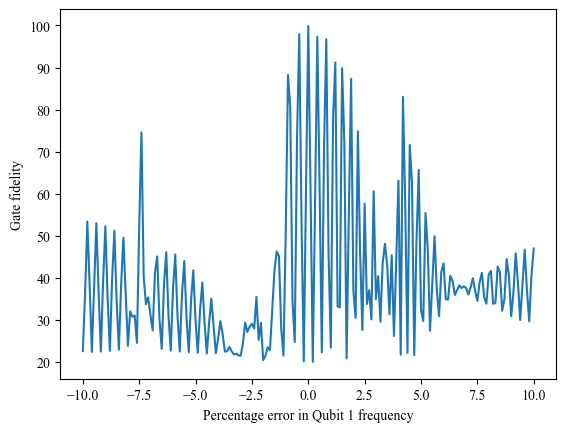

In [21]:
f1=[]
x=[]
for i in range(201):
    H_d = Hamiltonian([f_1+(i-100)*f_1/1000, f_2], delta, J, N)
    f1.append(100*gatefid(N,cnot_control_1,cnot_control_2,1,H_d))
    x.append((i-100)/10)
plt.plot(x,f1)
plt.xlabel("Percentage error in Qubit 1 frequency")
plt.ylabel("Gate fidelity")

Text(0, 0.5, 'Gate fidelity')

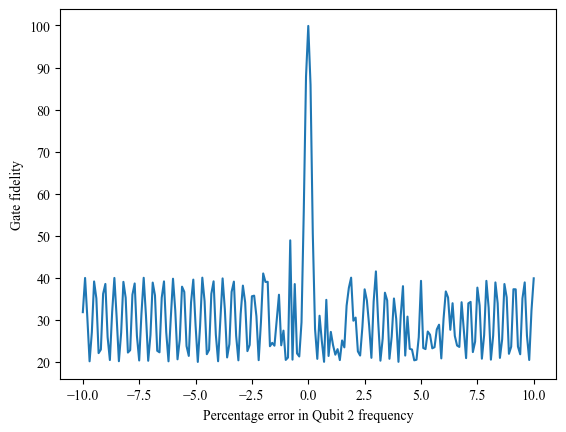

In [22]:
f2=[]
x=[]
for i in range(201):
    H_d = Hamiltonian([f_1, f_2+(i-100)*f_2/1000], delta, J, N)
    f2.append(100*gatefid(N,cnot_control_1,cnot_control_2,1,H_d))
    x.append((i-100)/10)
plt.plot(x,f2)
plt.xlabel("Percentage error in Qubit 2 frequency")
plt.ylabel("Gate fidelity")

Text(0, 0.5, 'Gate fidelity')

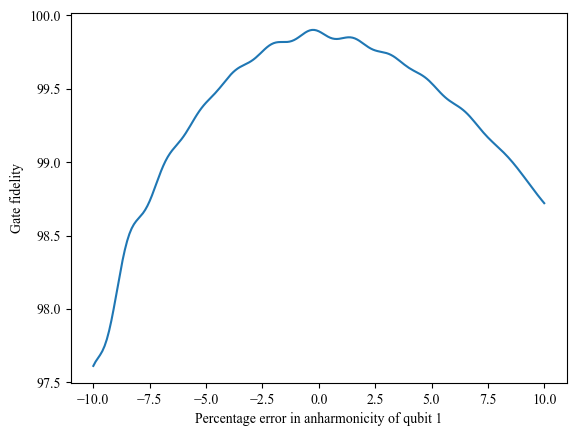

In [23]:
del1=[]
x=[]
for i in range(201):
    H_d = Hamiltonian([f_1, f_2], [delta_1+(i-100)*delta_1/1000, delta_2], J, N)
    del1.append(100*gatefid(N,cnot_control_1,cnot_control_2,1,H_d))
    x.append((i-100)/10)
plt.plot(x,del1)
plt.xlabel("Percentage error in anharmonicity of qubit 1")
plt.ylabel("Gate fidelity")

Text(0, 0.5, 'Gate fidelity')

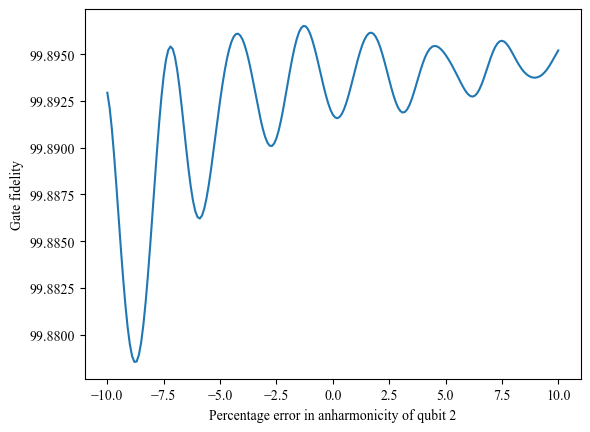

In [24]:
del2=[]
x=[]
for i in range(201):
    H_d = Hamiltonian([f_1, f_2], [delta_1, delta_2+(i-100)*delta_2/1000], J, N)
    del2.append(100*gatefid(N,cnot_control_1,cnot_control_2,1,H_d))
    x.append((i-100)/10)
plt.plot(x,del2)
plt.xlabel("Percentage error in anharmonicity of qubit 2")
plt.ylabel("Gate fidelity")

Text(0, 0.5, 'Gate fidelity')

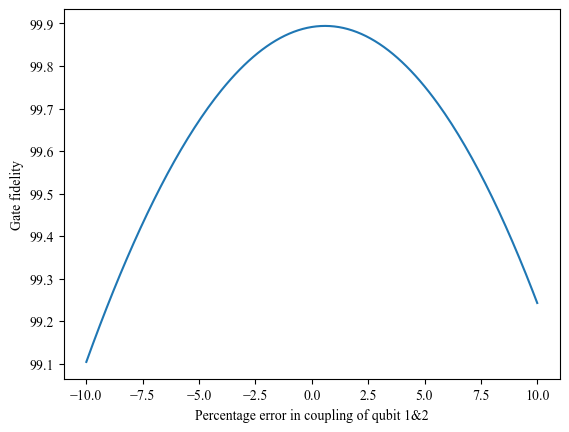

In [25]:
j1=[]
x=[]
for i in range(201):
    H_d = Hamiltonian([f_1, f_2], [delta_1, delta_2], [[ 0.0, 4.03+(i-100)*4.03/1000],[4.03+(i-100)*4.03/1000, 0.0]], N)
    j1.append(100*gatefid(N,cnot_control_1,cnot_control_2,1,H_d))
    x.append((i-100)/10)
plt.plot(x,j1)
plt.xlabel("Percentage error in coupling of qubit 1&2")
plt.ylabel("Gate fidelity")

Text(0, 0.5, 'Gate fidelity')

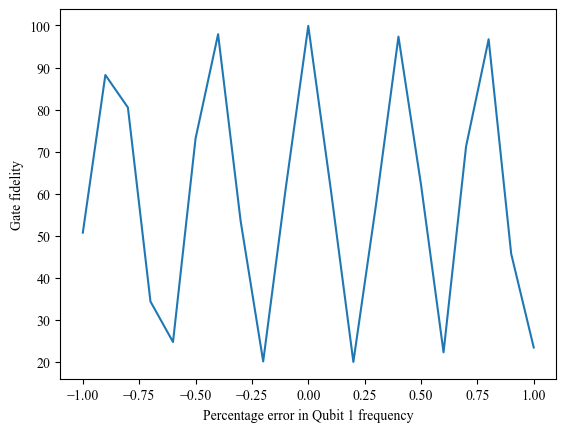

In [26]:
f1i=[]
xi=[]
for i in range(90,111):
    H_d = Hamiltonian([f_1+(i-100)*f_1/1000, f_2], delta, J, N)
    f1i.append(100*gatefid(N,cnot_control_1,cnot_control_2,1,H_d))
    xi.append((i-100)/10)
plt.plot(xi,f1i)
plt.xlabel("Percentage error in Qubit 1 frequency")
plt.ylabel("Gate fidelity")

Text(0, 0.5, 'Gate fidelity')

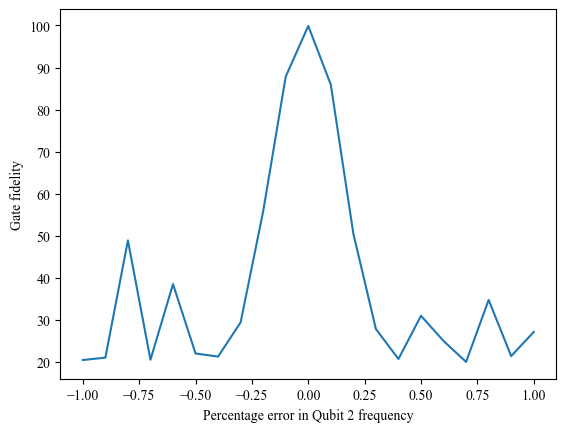

In [27]:
f2i=[]
xi=[]
for i in range(90,111):
    H_d = Hamiltonian([f_1, f_2+(i-100)*f_2/1000], delta, J, N)
    f2i.append(100*gatefid(N,cnot_control_1,cnot_control_2,1,H_d))
    xi.append((i-100)/10)
plt.plot(xi,f2i)
plt.xlabel("Percentage error in Qubit 2 frequency")
plt.ylabel("Gate fidelity")

Text(0, 0.5, 'Gate fidelity')

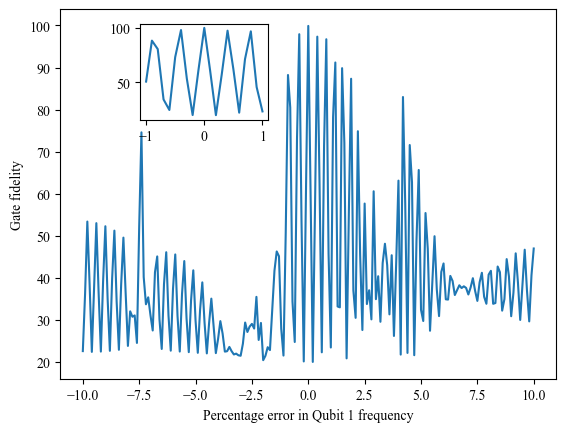

In [34]:
fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.25, 0.65, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(x,f1)
ax2.plot(xi,f1i)
ax1.set_xlabel("Percentage error in Qubit 1 frequency")
ax1.set_ylabel("Gate fidelity")

Text(0, 0.5, 'Gate fidelity')

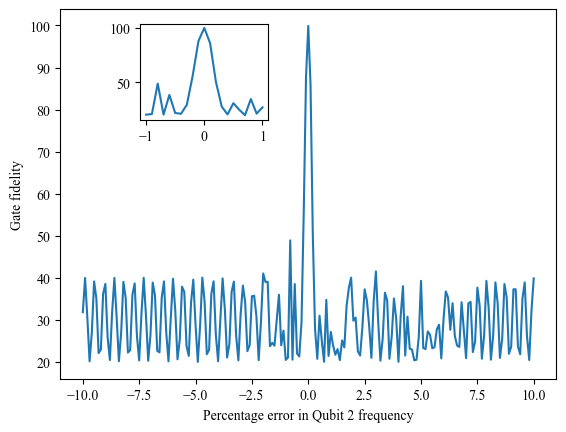

In [35]:
fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.25, 0.65, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(x,f2)
ax2.plot(xi,f2i)
ax1.set_xlabel("Percentage error in Qubit 2 frequency")
ax1.set_ylabel("Gate fidelity")

In [7]:
def gamma1(t):
    return(1-np.exp(-t/T1_1))
def gamma2(t):
    return(1-np.exp(-t/T1_2))
def lam1(t):
    return(1-np.exp(-2*t/T2star_1))
def lam2(t):
    return(1-np.exp(-2*t/T2star_2))

In [8]:
def AD(t):
    AD1=[]
    AD2=[]
    for i in range(N):
        sum1=Qobj(np.zeros([N,N]))
        sum2=Qobj(np.zeros([N,N]))
        for j in range(i,N):
            sum1=sum1+np.sqrt(math.comb(j,i)*((1-gamma1(t))**(j-i))*gamma1(t)**i)*basis(N,j-i)*basis(N,j).dag()
            sum2=sum2+np.sqrt(math.comb(j,i)*((1-gamma2(t))**(j-i))*gamma2(t)**i)*basis(N,j-i)*basis(N,j).dag()
        AD1.append(tensor(sum1,qeye(N)))
        AD2.append(tensor(qeye(N),sum2))
    return([AD1,AD2])

In [9]:
def PD(t):
    PD1=[]
    PD2=[]
    som1=np.identity(N)
    som1[1][1]=np.sqrt(1-lam1(t))
    som1[2][2]=np.sqrt(1-lam1(4*t))
    som2=np.identity(N)
    som2[1][1]=np.sqrt(1-lam2(t))
    som2[2][2]=np.sqrt(1-lam2(4*t))
    PD1.append(tensor(Qobj(som1),qeye(N)))
    PD2.append(tensor(qeye(N),Qobj(som2)))

    som1=np.zeros([N,N])
    som1[1][1]=np.sqrt(lam1(t))
    som2=np.zeros([N,N])
    som2[1][1]=np.sqrt(lam2(t))
    PD1.append(tensor(Qobj(som1),qeye(N)))
    PD2.append(tensor(qeye(N),Qobj(som2)))

    som1=np.zeros([N,N])
    som1[2][2]=np.sqrt(lam1(4*t))
    som2=np.zeros([N,N])
    som2[2][2]=np.sqrt(lam2(4*t))
    PD1.append(tensor(Qobj(som1),qeye(N)))
    PD2.append(tensor(qeye(N),Qobj(som2)))
    return([PD1,PD2])

In [10]:
def MAP(rho,t):
    A=AD(t)
    P=PD(t)
    for i in range(len(A)):
        sum = Qobj(np.zeros([N**2,N**2]))
        for j in range(len(A[i])):
            sum = sum + Qobj(A[i][j].full())*rho*Qobj(((A[i][j]).dag()).full())
        rho = sum
    for i in range(len(P)):
        sum = Qobj(np.zeros([N**2,N**2]))
        for j in range(len(P[i])):
            sum= sum + Qobj(P[i][j].full())*rho*Qobj(((P[i][j]).dag()).full())
        rho = sum
    #print(rho.tr())
    return(rho)

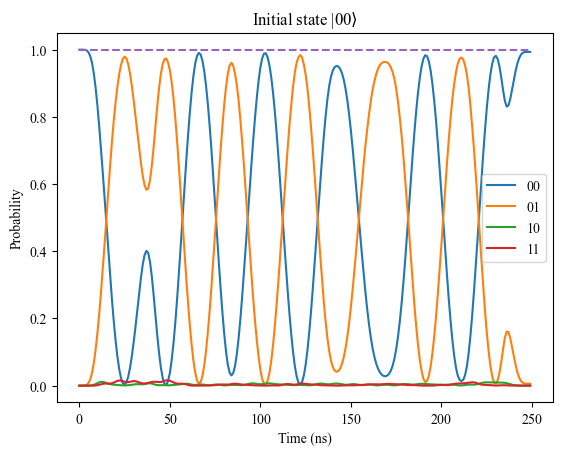

In [38]:
from scipy.linalg import expm
ij=0
probsij=[]
for i in range(N**2):
    probsij.append([])
st=basis(N**2,ij)*basis(N**2,ij).dag()
U=identity(N**2)
fid=[]
SCALING=1

for i in range(len(cnot_control_1)):
    u1=Qobj(expm(-0.001*1j*(H_d.full()+SCALING*cnot_control_1[i]*H_c[0].full()+SCALING*cnot_control_2[i]*H_c[1].full())))
    st=MAP(u1*st*u1.dag(),0.001)
    for j in range(N**2):
        probsij[j].append((st*basis(N**2,j)*basis(N**2,j).dag()).tr())
#plt.yscale("log")
for i in [0,1,N,N+1]:#range(N**2):
    plt.plot(probsij[i],label=str(int(i/N))+str(i%N))
plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Probability")
plt.title("Initial state |00$\\rangle$")
plt.plot(np.ones(len(probsij[0])),'--')
plt.savefig("IS00.png")

In [39]:
probsij[0][-1]

(0.9933739063704625+4.824411621908737e-17j)

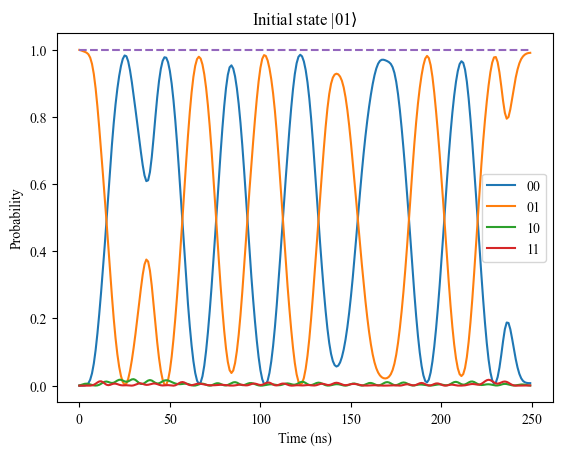

In [40]:
from scipy.linalg import expm
ij=1
probsij=[]
for i in range(N**2):
    probsij.append([])
st=basis(N**2,ij)*basis(N**2,ij).dag()
U=identity(N**2)
fid=[]
SCALING=0.98655

for i in range(len(cnot_control_1)):
    u1=Qobj(expm(-0.001*1j*(H_d.full()+SCALING*cnot_control_1[i]*H_c[0].full()+SCALING*cnot_control_2[i]*H_c[1].full())))
    st=MAP(u1*st*u1.dag(),0.001)
    for j in range(N**2):
        probsij[j].append((st*basis(N**2,j)*basis(N**2,j).dag()).tr())
#plt.yscale("log")
for i in [0,1,N,N+1]:#range(N**2):
    plt.plot(probsij[i],label=str(int(i/N))+str(i%N))
plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Probability")
plt.title("Initial state |01$\\rangle$")
plt.plot(np.ones(len(probsij[0])),'--')
plt.savefig("IS01.png")

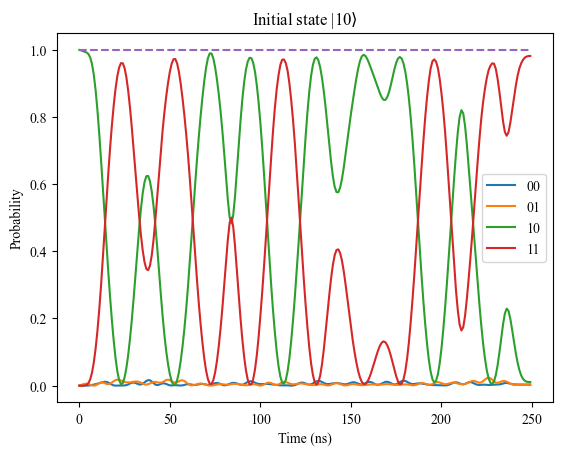

In [41]:
from scipy.linalg import expm
ij=N
probsij=[]
for i in range(N**2):
    probsij.append([])
st=basis(N**2,ij)*basis(N**2,ij).dag()
U=identity(N**2)
fid=[]

SCALING=0.98655

for i in range(len(cnot_control_1)):
    u1=Qobj(expm(-0.001*1j*(H_d.full()+SCALING*cnot_control_1[i]*H_c[0].full()+SCALING*cnot_control_2[i]*H_c[1].full())))
    st=MAP(u1*st*u1.dag(),0.001)
    for j in range(N**2):
        probsij[j].append((st*basis(N**2,j)*basis(N**2,j).dag()).tr())
#plt.yscale("log")
for i in [0,1,N,N+1]:#range(N**2):
    plt.plot(probsij[i],label=str(int(i/N))+str(i%N))
plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Probability")
plt.title("Initial state |10$\\rangle$")
plt.plot(np.ones(len(probsij[0])),'--')
plt.savefig("IS10.png")

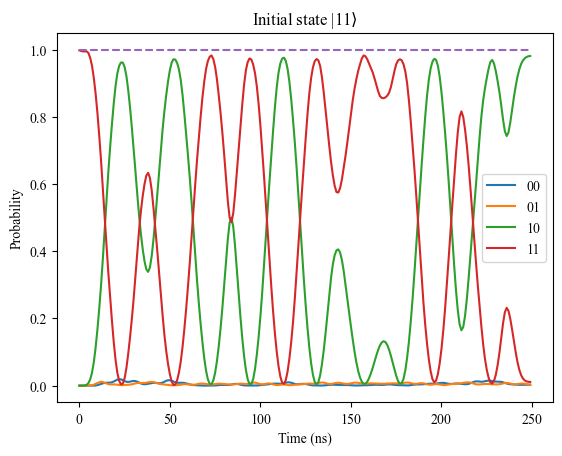

In [42]:
from scipy.linalg import expm
ij=N+1
probsij=[]
for i in range(N**2):
    probsij.append([])
st=basis(N**2,ij)*basis(N**2,ij).dag()
U=identity(N**2)
fid=[]

SCALING=0.98655

for i in range(len(cnot_control_1)):
    u1=Qobj(expm(-0.001*1j*(H_d.full()+SCALING*cnot_control_1[i]*H_c[0].full()+SCALING*cnot_control_2[i]*H_c[1].full())))
    st=MAP(u1*st*u1.dag(),0.001)
    for j in range(N**2):
        probsij[j].append((st*basis(N**2,j)*basis(N**2,j).dag()).tr())
#plt.yscale("log")
for i in [0,1,N,N+1]:#range(N**2):
    plt.plot(probsij[i],label=str(int(i/N))+str(i%N))
plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Probability")
plt.title("Initial state |11$\\rangle$")
plt.plot(np.ones(len(probsij[0])),'--')
plt.savefig("IS11.png")

In [29]:
probsij[3][-1]

(0.9811531280564186-6.661128020177165e-16j)

In [11]:
b  = qutip.Bloch()

#Vizualising Blch sphere
#b.make_sphere()
b.view = [90,0]
b.clear()

In [12]:

# b.make_sphere()
def plot(rho, num):
    eigenvalues, eigenvectors = np.linalg.eig(rho.full())
    idx = eigenvalues.argsort()[::-1]  # Sort by eigenvalue in descending order
    eigenvectors = eigenvectors[:, idx]  # Sort eigenvectors accordingly
    dominant_eigenvector = eigenvectors[:, 0]
    state = Qobj(dominant_eigenvector / np.linalg.norm(dominant_eigenvector))

    bloch_vector = [
        expect(sigmax(), state),
        expect(sigmay(), state),
        expect(sigmaz(), state)
    ]

    if(num==0):
        state=state.full()
        b.add_points(np.array(bloch_vector)[:, np.newaxis], 'm','c')
        b.render()
    #
    else:
        b.add_states(state)
        b.render()

# b.make_sphere()
#rho = Qobj(np.array([[-9,10],[-12,8]]))#this is the input
#plot(rho,0)# if second parameter = 0, it will plot a point, if 1 it will plot a vector
#b.show()

In [35]:
def HamiltonianSQ(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-f[i])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + 0*(2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham
H_dSQ = HamiltonianSQ(f, delta, J, N)
H_cSQ = [(2*np.pi)*Qobj(a[0].dag() + a[0])/2]

In [38]:
ggg=[0.0012864741843387347, 0.0034969993980696547, 0.008506190349491677, 0.018514828519579474, 0.036061961771874894, 0.06285271768057651, 0.09802657538307226, 0.13680710659325385, 0.17085140034037768, 0.1909296978016222, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1909296978016222, 0.17085140034037768, 0.13680710659325385, 0.09802657538307226, 0.06285271768057651, 0.036061961771874894, 0.018514828519579474, 0.008506190349491677, 0.0034969993980696547, 0.0012864741843387347]

In [139]:
print(ggg)

[0.0012864741843387347, 0.0034969993980696547, 0.008506190349491677, 0.018514828519579474, 0.036061961771874894, 0.06285271768057651, 0.09802657538307226, 0.13680710659325385, 0.17085140034037768, 0.1909296978016222, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1909296978016222, 0.17085140034037768, 0.13680710659325385, 0.09802657538307226, 0.06285271768057651, 0.036061961771874894, 0.018514828519579474, 0.008506190349491677, 0.0034969993980696547, 0.0012864741843387347]


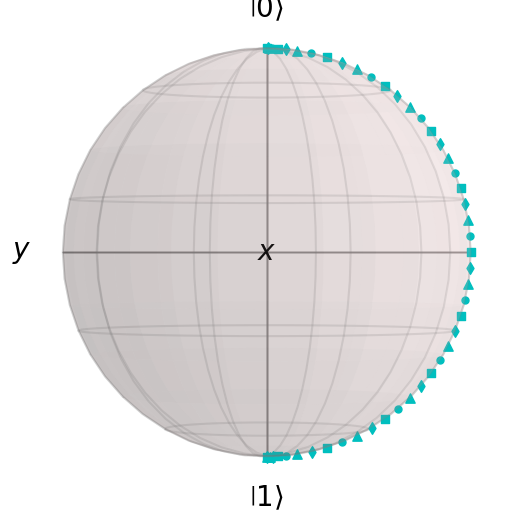

In [136]:
from scipy.linalg import expm
import cmath
U=identity(N**2)
U=Qobj(U.full(),dims=[[N,N],[N,N]])
st=basis(N**2,0)*basis(N**2,0).dag()
fid=[]

for i in range(len(ggg)):
    u1=Qobj(expm(-0.001*1j*(H_dSQ.full()+(12.6556/0.1936)*ggg[i]*H_cSQ[0].full())))#12.65355/0.1936,12.654011
    st=MAP(u1*st*u1.dag(),0.001*0)
    plot(Qobj((Qobj(st.full(),dims=[[N,N],[N,N]]).ptrace(0)).full()[:2,:2]),0)

b.show()
b.clear()

In [137]:
st

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 5.37994124e-04+4.61632956e-19j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -2.31876639e-02+1.88545400e-04j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -8.51568969e-06+3.61362565e-05j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-2.3

In [161]:
ggg3=np.array([-1.64324532e-17,  5.32130757e-02,  1.77235157e-01,  3.19512519e-01,
        4.40463254e-01,  5.23246862e-01,  5.68039850e-01,  5.81384513e-01,
        5.70415841e-01,  5.41703413e-01,  5.01673370e-01,  4.56774738e-01,
        4.12962665e-01,  3.74906061e-01,  3.45476056e-01,  3.25739455e-01,
        3.15325313e-01,  3.12918942e-01,  3.16709899e-01,  3.24728128e-01,
        3.35068800e-01,  3.46029630e-01,  3.56185538e-01,  3.64420822e-01,
        3.69934948e-01,  3.72235303e-01,  3.71127660e-01,  3.66711783e-01,
        3.59385358e-01,  3.49854797e-01,  3.39146903e-01,  3.28611418e-01,
        3.19901137e-01,  3.14912837e-01,  3.15667596e-01,  3.24103460e-01,
        3.41751941e-01,  3.69287616e-01,  4.06000497e-01,  4.49351741e-01,
        4.94872815e-01,  5.36599196e-01,  5.67883726e-01,  5.82028024e-01,
        5.72207010e-01,  5.30953779e-01,  4.50974285e-01,  3.30654115e-01,
        1.85551601e-01,  5.63405729e-02])
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
ggg3*26.5

array([-0.000000, 1.410147, 4.696732, 8.467082, 11.672276, 13.866042,
       15.053056, 15.406690, 15.116020, 14.355140, 13.294344, 12.104531,
       10.943511, 9.935011, 9.155115, 8.632096, 8.356121, 8.292352,
       8.392812, 8.605295, 8.879323, 9.169785, 9.438917, 9.657152,
       9.803276, 9.864236, 9.834883, 9.717862, 9.523712, 9.271152,
       8.987393, 8.708203, 8.477380, 8.345190, 8.365191, 8.588742,
       9.056426, 9.786122, 10.759013, 11.907821, 13.114130, 14.219879,
       15.048919, 15.423743, 15.163486, 14.070275, 11.950819, 8.762334,
       4.917117, 1.493025])

In [3]:
data = np.loadtxt('ctrl_amps_final_SX_n_ts_60_3_level(MODIFIED).txt')

In [4]:
data[:,1]

array([-0.      ,  0.587598,  2.194497,  4.482449,  7.024832,  9.412985,
       11.359649, 12.731607, 13.513118, 13.750876, 13.517411, 12.898875,
       11.99602 , 10.925367,  9.812314,  8.776376,  7.914331,  7.288533,
        6.923628,  6.810394,  6.913771,  7.182189,  7.556369,  7.976686,
        8.388866,  8.747412,  9.017499,  9.175466,  9.208458,  9.113853,
        8.898859,  8.580223,  8.184022,  7.744943,  7.305281,  6.912552,
        6.616494,  6.464914,  6.498992,  6.748093,  7.224616,  7.919101,
        8.797046,  9.79872 , 10.84335 , 11.837789, 12.687246, 13.304404,
       13.614083, 13.55324 , 13.070621, 12.131408, 10.733321,  8.932885,
        6.869303,  4.761944,  2.865895,  1.399038,  0.476006,  0.069928])

In [15]:
N = 3
f_1 = 5.03648*(10**3)
f_2 = 4.96961*(10**3)
delta_1 = -268
delta_2 = -269
T1_1 = 25
T1_2 = 37
T2star_1 = 11
T2star_2 = 28
# the lists of variables for all 6 qubits.
f = [f_1, f_2] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2] #the coefficient for the Kerr term
#      33    34     43    44
J = [[ 0.0, 4.25],[4.25, 0.0]]

# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))

a = [a_1, a_2]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)

def HamiltonianQ3(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-f[i])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + 0*(2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_dQ3 = HamiltonianQ3(f, delta, J, N)
H_cQ3 = [ 26.5*(2*np.pi)*Qobj(a[0].dag() + a[0])/2]

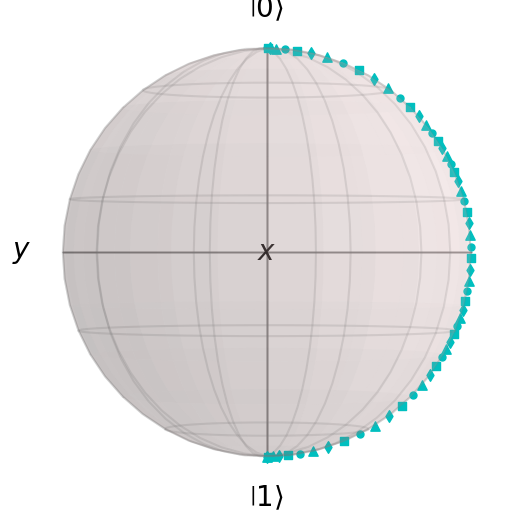

In [16]:
from scipy.linalg import expm
import cmath
U=identity(N**2)
#U=Qobj(U.full(),dims=[[N,N],[N,N]])
st=basis(N**2,0)*basis(N**2,0).dag()
fid=[]

for i in range(len(data[:,1])):
    u1=Qobj(expm(-0.001*1j*(H_dQ3.full()+data[:,1][i]*H_cQ3[0].full()/26.5)))
    U=u1*U
    st=MAP(u1*st*u1.dag(),0.001)
    plot(Qobj((Qobj(st.full(),dims=[[N,N],[N,N]]).ptrace(0)).full()[:2,:2]),0)

b.show()
b.clear()

In [17]:
U/U[0][N]

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-1.76407874e-02+1.67425505e-04j -0.00000000e+00+0.00000000e+00j
  -0.00000000e+00+0.00000000e+00j  1.00000000e+00+3.46944695e-18j
  -0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
  -6.96531942e-04-7.18295693e-04j -0.00000000e+00+0.00000000e+00j
  -0.00000000e+00+0.00000000e+00j]
 [-0.00000000e+00+0.00000000e+00j -1.76407874e-02+1.67425505e-04j
  -0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
   1.00000000e+00+3.46944695e-18j -0.00000000e+00+0.00000000e+00j
  -0.00000000e+00+0.00000000e+00j -6.96531942e-04-7.18295693e-04j
  -0.00000000e+00+0.00000000e+00j]
 [-0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
  -1.13736647e-02-1.34857393e-02j -0.00000000e+00+0.00000000e+00j
  -0.00000000e+00+0.00000000e+00j  6.37423990e-01+7.70513243e-01j
  -0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
   1.09470174e-04-9.94545992e-04j]
 [ 1.

In [18]:
(st*st).tr()

0.9954518044388679

In [19]:
st

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 2.57288205e-03+5.86207993e-18j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.75204121e-02+8.86975999e-04j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   3.24548642e-06-1.47882777e-06j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-1.7

Text(0, 0.5, 'MHz')

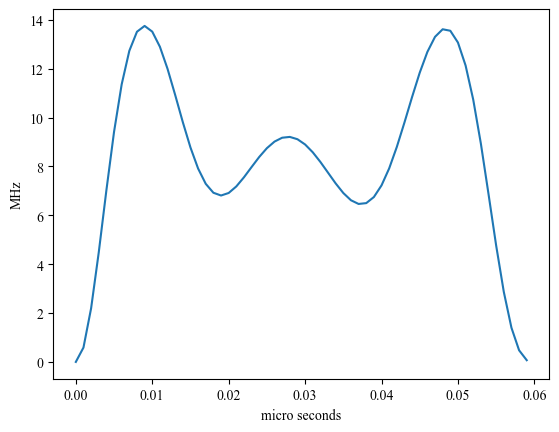

In [21]:
plt.plot(data[:,0],data[:,1])
plt.xlabel("micro seconds")
plt.ylabel("MHz")